In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
from imblearn.over_sampling import SMOTE
#%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold

from scipy.stats import norm
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

#DS
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#KNN
from sklearn.neighbors import KNeighborsClassifier

#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

#LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV

#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 1. Loading the dataset

In [2]:
#loading the data from CSV file 
data=pd.read_csv('final_Binary.csv')
data.head()

'''dataFeatures= ['Side Chest Airbag-Driver', 'Side Chest Airbag-Passenger',
       'AEB Vulnerable Road Users', 'Side Head Airbag-Driver',
       'Side Head Airbag-Passenger', 'Seatbelt Reminder-Passenger',
       'AEB Car-to-Car', 'Belt Loadlimiter-Rear', 'Belt Pretensioner-Rear',
       'Side Head Airbag-Rear', 'Lane Assist System', 'Seatbelt Reminder-Rear',
       'Safety Assist', 'Speed Assistance', 'Adult Occupant',
       'Centre Airbag-Driver', 'Child Occupant', 'Tested Model',
       'Isofix/i-Size-Passenger'] '''

dataFeatures= ['Adult Occupant', 'Belt Pretensioner-Rear', 'Safety Assist',
       'Child Occupant', 'Class', 'Side Pelvis Airbag-Rear',
       'AEB Vulnerable Road Users']


In [3]:
# print the columns in the dataset
data.columns

Index(['Adult Occupant', 'Belt Pretensioner-Rear', 'Safety Assist',
       'Child Occupant', 'Class', 'Side Pelvis Airbag-Rear',
       'AEB Vulnerable Road Users', 'Rate'],
      dtype='object')

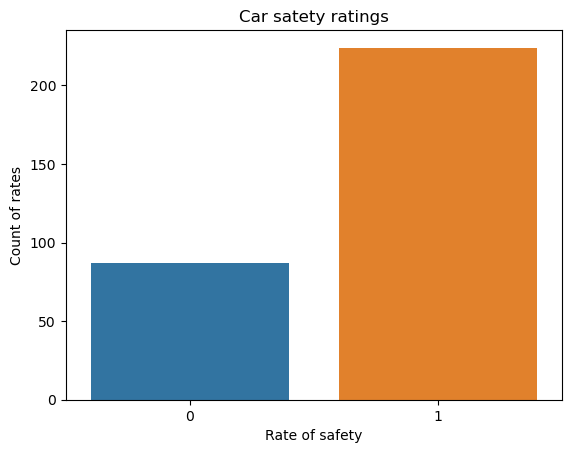

In [4]:
#Data presentation 

sns.countplot(data["Rate"])
plt.xlabel("Rate of safety")
plt.ylabel("Count of rates")
plt.title("Car satety ratings")
plt.show()

In [5]:
'''# Create a MinMaxScaler object for numrical data
scaler = MinMaxScaler()

# Scaling the raw input features 
feature_cols=data.columns[:-1]
X= scaler.fit_transform(data[feature_cols])

print(f"The range of feature inputs are within {X.min()} to {X.max()}")'''

'# Create a MinMaxScaler object for numrical data\nscaler = MinMaxScaler()\n\n# Scaling the raw input features \nfeature_cols=data.columns[:-1]\nX= scaler.fit_transform(data[feature_cols])\n\nprint(f"The range of feature inputs are within {X.min()} to {X.max()}")'

## 2. Split the dataset 

In [6]:

from sklearn.model_selection import StratifiedShuffleSplit

feature_cols=data.columns[:-1]
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, random_state=0)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data['Rate']))

# Create the dataframes


X_train = data.loc[train_idx, dataFeatures]
y_train = data.loc[train_idx, 'Rate']

X_test  = data.loc[test_idx, dataFeatures]
y_test  = data.loc[test_idx, 'Rate']

print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (217, 7), y_train: (217,)
Testing dataset shape, X_test: (94, 7), y_test: (94,)


## 3. Smoot 

before smote


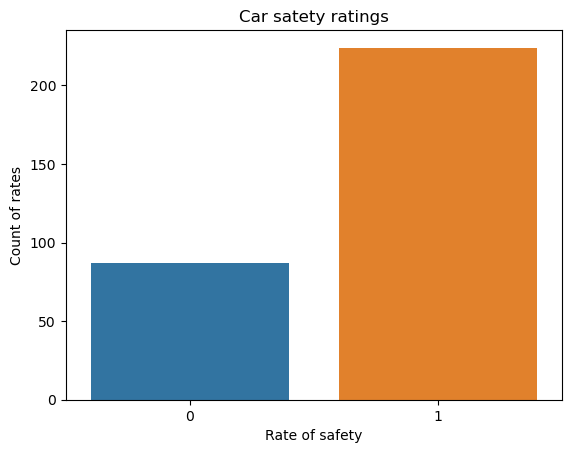

after smote


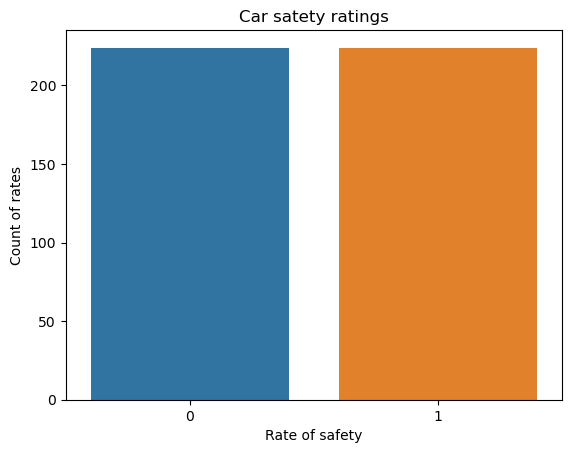

In [7]:
X= data.loc[:,dataFeatures]
y= data.loc[:,["Rate"]]

smote = SMOTE(sampling_strategy='minority')
# smote = SMOTE(sampling_strategy=0.5)
x_sm, y_sm = smote.fit_resample(X, y)

print("before smote")
sns.countplot(y["Rate"])
plt.xlabel("Rate of safety")
plt.ylabel("Count of rates")
plt.title("Car satety ratings")
plt.show()

print("after smote")
sns.countplot(y_sm["Rate"])
plt.xlabel("Rate of safety")
plt.ylabel("Count of rates")
plt.title("Car satety ratings")
plt.show()


In [8]:


def splitTrain (model):
    # Initialize the Stratified K-fold Cross-validator with 5 splits
    sk=StratifiedKFold(n_splits=5)

    # Initialize the array to store the accuracy scores
    tr_accuracy_scores = []
    tst_accuracy_scores = []

    # Perform cross-validation

    flg = True
    for train_index, test_index in sk.split(X, y):
        # Split the data into training and test sets
        x_train_fold, x_test_fold = X.loc[train_index,:], X.loc[test_index,:]
        y_train_fold, y_test_fold = y.loc[train_index,:], y.loc[test_index,:]

        #Fit the model to the training data
        model.fit(x_train_fold, np.ravel(y_train_fold))
        # Make predictions on the test data
        yTrain_pred = model.predict(x_train_fold)
        yTest_pred = model.predict(x_test_fold)

        # Calculate the accuracy score and append it to the list
        tr_accuracy_scores.append(accuracy_score(y_train_fold, yTrain_pred))
        tst_accuracy_scores.append(accuracy_score(y_test_fold, yTest_pred))
        #Data presentation 

    # Print the accuracy scores for each fold
    print("Accuracy scores for each training fold: ", tr_accuracy_scores)
    print("Accuracy scores for each testing fold: ", tst_accuracy_scores)

    # Calculate the mean accuracy scores
    print("Traning Mean accuracy score: ", np.mean(tr_accuracy_scores))
    print("Testing Mean accuracy score: ", np.mean(tst_accuracy_scores))

## 4. Data normalization 

In [9]:
y_train.value_counts(normalize=True)

1    0.718894
0    0.281106
Name: Rate, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

1    0.723404
0    0.276596
Name: Rate, dtype: float64

## 4. Models 

### 4.1 Decision Tree 

before optimization

In [11]:
# DecisionTreeClassifier
#importing the classfier
clf=DecisionTreeClassifier(random_state=0)
splitTrain (clf)

Accuracy scores for each training fold:  [1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy scores for each testing fold:  [0.9841269841269841, 0.967741935483871, 0.7903225806451613, 0.9516129032258065, 0.7258064516129032]
Traning Mean accuracy score:  1.0
Testing Mean accuracy score:  0.8839221710189452


After optimization

In [12]:
# DecisionTree opt


#optimization
param_grid={
"max_depth":[2,4,6],
"min_samples_split":[2,5,10],
"min_samples_leaf":[1,2,4]}
grid_search= GridSearchCV(estimator=clf,param_grid=param_grid,cv=5)

splitTrain(grid_search)

Accuracy scores for each training fold:  [0.9717741935483871, 0.963855421686747, 0.9718875502008032, 0.9397590361445783, 0.9678714859437751]
Accuracy scores for each testing fold:  [0.9841269841269841, 0.9838709677419355, 0.7741935483870968, 0.9516129032258065, 0.7580645161290323]
Traning Mean accuracy score:  0.9630295375048583
Testing Mean accuracy score:  0.890373783922171


### 4.2 KNN

Before optimization

In [13]:
# KNN
#importing the classfier

kCls=KNeighborsClassifier()
splitTrain(kCls)


Accuracy scores for each training fold:  [0.9395161290322581, 0.9357429718875502, 0.9678714859437751, 0.9437751004016064, 0.9558232931726908]
Accuracy scores for each testing fold:  [0.9206349206349206, 0.9193548387096774, 0.7903225806451613, 0.9838709677419355, 0.8064516129032258]
Traning Mean accuracy score:  0.9485457960875762
Testing Mean accuracy score:  0.884126984126984


After optimization

In [14]:
#TODO: Write the code here

### 4.3 GradientBoosting

Before optimization

In [15]:
# GradientBoostingClassifier
#importing the classfier

gb_clf = GradientBoostingClassifier()
splitTrain(gb_clf)


Accuracy scores for each training fold:  [1.0, 0.9959839357429718, 1.0, 1.0, 1.0]
Accuracy scores for each testing fold:  [0.9682539682539683, 1.0, 0.7903225806451613, 0.9838709677419355, 0.7419354838709677]
Traning Mean accuracy score:  0.9991967871485944
Testing Mean accuracy score:  0.8968766001024064


After optimization

In [27]:
# # optimizing the GradientBoostingClassifier using RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators' : [10,15, 20, 100], 
                'learning_rate' : [0.001, 0.02], 
                'max_depth' : [4,6,8,10],
                'subsample' : [0.7 ,0.5 , 0.2 ],
                'max_features' :[3,4,5,6,7]
                }

opt_gb_clf = GridSearchCV(estimator= gb_clf, 
                    param_grid= parameters, 
                    cv= 2,
                    n_jobs= -1)


splitTrain(opt_gb_clf)


Accuracy scores for each training fold:  [0.8467741935483871, 0.8473895582329317, 0.9156626506024096, 0.963855421686747, 0.9879518072289156]
Accuracy scores for each testing fold:  [0.7936507936507936, 0.8225806451612904, 0.7741935483870968, 0.9838709677419355, 0.7580645161290323]
Traning Mean accuracy score:  0.9123267262598782
Testing Mean accuracy score:  0.8264720942140297


In [26]:
print(opt_gb_clf.best_estimator_)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, max_features=3,
                           n_estimators=10, subsample=0.7)


### 4.4 LogisticRegression

Before optimization

In [18]:
#LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#Grid search cross validation
lr=LogisticRegression()
splitTrain(lr)

Accuracy scores for each training fold:  [0.9395161290322581, 0.8995983935742972, 0.963855421686747, 0.9036144578313253, 0.9317269076305221]
Accuracy scores for each testing fold:  [0.9047619047619048, 1.0, 0.7903225806451613, 0.9838709677419355, 0.7258064516129032]
Traning Mean accuracy score:  0.9276622619510299
Testing Mean accuracy score:  0.880952380952381


After optimization

In [19]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2","elasticnet"], 'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}
logreg=LogisticRegression()
op_lr=GridSearchCV(logreg,grid,cv=10)

splitTrain(op_lr)

Accuracy scores for each training fold:  [0.9314516129032258, 0.8995983935742972, 0.963855421686747, 0.9036144578313253, 0.927710843373494]
Accuracy scores for each testing fold:  [0.9206349206349206, 1.0, 0.7903225806451613, 0.967741935483871, 0.7096774193548387]
Traning Mean accuracy score:  0.9252461458738178
Testing Mean accuracy score:  0.8776753712237584


### 4.5 Random Forest

Before optimization

In [20]:
#RandomForestClassifier
RF= RandomForestClassifier(random_state= 0)
splitTrain (RF)

Accuracy scores for each training fold:  [1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy scores for each testing fold:  [0.9523809523809523, 1.0, 0.7903225806451613, 0.967741935483871, 0.7741935483870968]
Traning Mean accuracy score:  1.0
Testing Mean accuracy score:  0.8969278033794164


After optimization

In [21]:

#RandomForest optimization
random_grid={
"max_depth":[2,4,6],
"min_samples_split":[2,5,10],
"min_samples_leaf":[1,2,4]}
random_search= GridSearchCV(estimator=RF,param_grid=random_grid,cv=5)


print("random_search")
splitTrain(random_search)


random_search
Accuracy scores for each training fold:  [0.9395161290322581, 0.927710843373494, 0.9799196787148594, 0.927710843373494, 0.9799196787148594]
Accuracy scores for each testing fold:  [0.9365079365079365, 1.0, 0.7903225806451613, 0.9516129032258065, 0.7580645161290323]
Traning Mean accuracy score:  0.9509554346417929
Testing Mean accuracy score:  0.8873015873015874


## 5. Training and Evaluation

### 5.1 Before Optimazation 

In [22]:
# Base models 
kCls=KNeighborsClassifier()
print("KNN")
splitTrain(kCls)

gb_clf2 = GradientBoostingClassifier()
print("GradientBoosting")
splitTrain(gb_clf2)

logreg=LogisticRegression()
print("LogisticRegression")
splitTrain(logreg)

RF= RandomForestClassifier()
print("RandomForest")
splitTrain(RF)

clf=DecisionTreeClassifier()
print("DecisionTree")
splitTrain(clf)






KNN
Accuracy scores for each training fold:  [0.9395161290322581, 0.9357429718875502, 0.9678714859437751, 0.9437751004016064, 0.9558232931726908]
Accuracy scores for each testing fold:  [0.9206349206349206, 0.9193548387096774, 0.7903225806451613, 0.9838709677419355, 0.8064516129032258]
Traning Mean accuracy score:  0.9485457960875762
Testing Mean accuracy score:  0.884126984126984
GradientBoosting
Accuracy scores for each training fold:  [1.0, 0.9959839357429718, 1.0, 1.0, 1.0]
Accuracy scores for each testing fold:  [0.9682539682539683, 1.0, 0.7903225806451613, 0.9838709677419355, 0.7419354838709677]
Traning Mean accuracy score:  0.9991967871485944
Testing Mean accuracy score:  0.8968766001024064
LogisticRegression
Accuracy scores for each training fold:  [0.9395161290322581, 0.8995983935742972, 0.963855421686747, 0.9036144578313253, 0.9317269076305221]
Accuracy scores for each testing fold:  [0.9047619047619048, 1.0, 0.7903225806451613, 0.9838709677419355, 0.7258064516129032]
Traning

### After Optimization

In [23]:

print("KNN")
splitTrain(kCls)

print("GradientBoosting")
splitTrain(gb_clf2)


print("LogisticRegression")
splitTrain(op_lr)

print("RandomForest")
splitTrain(random_search)

print("DecisionTree")
splitTrain(grid_search)

KNN
Accuracy scores for each training fold:  [0.9395161290322581, 0.9357429718875502, 0.9678714859437751, 0.9437751004016064, 0.9558232931726908]
Accuracy scores for each testing fold:  [0.9206349206349206, 0.9193548387096774, 0.7903225806451613, 0.9838709677419355, 0.8064516129032258]
Traning Mean accuracy score:  0.9485457960875762
Testing Mean accuracy score:  0.884126984126984
GradientBoosting
Accuracy scores for each training fold:  [1.0, 0.9959839357429718, 1.0, 1.0, 1.0]
Accuracy scores for each testing fold:  [0.9682539682539683, 1.0, 0.7903225806451613, 0.9838709677419355, 0.7419354838709677]
Traning Mean accuracy score:  0.9991967871485944
Testing Mean accuracy score:  0.8968766001024064
LogisticRegression
Accuracy scores for each training fold:  [0.9354838709677419, 0.8995983935742972, 0.963855421686747, 0.9036144578313253, 0.927710843373494]
Accuracy scores for each testing fold:  [0.9206349206349206, 1.0, 0.7903225806451613, 0.967741935483871, 0.7096774193548387]
Traning M